# SAM-VMNet Comprehensive Evaluation

Runs inference on the test set, computes rich per-image and global metrics, and generates 7 publication-quality charts + a JSON report.

**Outputs** (saved to `OUTPUT_DIR`):

| File | Description |
|------|-------------|
| `confusion_matrix.png` | Annotated heatmap with counts + percentages |
| `precision_recall_curve.png` | PR curve with mAP, iso-F1 reference lines |
| `roc_curve.png` | ROC curve with AUC, diagonal baseline |
| `metric_distributions.png` | Violin+box+strip plots for Dice, IoU, HD95, ASD |
| `threshold_analysis.png` | F1/IoU/Precision/Recall across thresholds 0.1–0.9 |
| `qualitative_results.png` | Best 4 + worst 4 predictions grid |
| `metrics_dashboard.png` | Clean summary table of all aggregate metrics |
| `metrics.json` | Full metrics (global + per-image) for programmatic use |

## 0. Configuration

Edit the variables below before running.

In [41]:
# ========================= EDIT THESE =========================
BRANCH      = 2                    # 1 = VM-UNet, 2 = SAM-VMNet
DATA_PATH   = './data/vessel/'     # dataset root
WEIGHTS     = './saved/branch2/checkpoints/best-epoch77-loss0.7787.pth'
THRESHOLD   = 0.5                  # binarization threshold
OUTPUT_DIR  = './evaluation/'      # where charts + JSON are saved
BATCH_SIZE  = 1                    # inference batch size
DEVICE      = None                 # None = auto-detect, or 'cuda:0' / 'mps' / 'cpu'
# ==============================================================

### Install dependencies (run once)

In [42]:
# Full dependency chain: notebook -> dataset.py -> utils.py -> med_sam/ -> models/vmamba.py
%pip install \
    torch torchvision \
    numpy scipy matplotlib Pillow \
    opencv-python scikit-image scikit-learn \
    h5py medpy SimpleITK \
    tqdm ipywidgets \
    einops timm thop

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 1. Imports & Setup

In [43]:
import sys, os, json, warnings, importlib
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
)
from medpy.metric.binary import hd95, assd

# Force-reload model modules so on-disk edits take effect
import models.vmunet.vmamba as _vmamba_mod
importlib.reload(_vmamba_mod)

# Inject pure-PyTorch selective_scan_fn fallback if CUDA mamba_ssm is unavailable
if not hasattr(_vmamba_mod, 'selective_scan_fn'):
    def _selective_scan_fn(u, delta, A, B, C, D=None, z=None,
                           delta_bias=None, delta_softplus=False,
                           return_last_state=False):
        batch, dim, length = u.shape
        n_state = A.shape[1]
        if delta_bias is not None:
            delta = delta + delta_bias.unsqueeze(0).unsqueeze(-1)
        if delta_softplus:
            delta = F.softplus(delta)
        deltaA = torch.exp(torch.einsum('b d l, d n -> b d l n', delta, A))
        if B.dim() == 4:
            G = B.shape[1]
            D_per_group = dim // G
            deltaB_u = torch.zeros(batch, dim, length, n_state,
                                   device=u.device, dtype=u.dtype)
            for g in range(G):
                s, e = g * D_per_group, (g + 1) * D_per_group
                deltaB_u[:, s:e] = torch.einsum(
                    'b d l, b n l -> b d l n',
                    delta[:, s:e] * u[:, s:e], B[:, g])
        else:
            deltaB_u = torch.einsum('b d l, b n l -> b d l n', delta * u, B)
        x = torch.zeros(batch, dim, n_state, device=u.device, dtype=u.dtype)
        ys = []
        for l_idx in range(length):
            x = deltaA[:, :, l_idx] * x + deltaB_u[:, :, l_idx]
            if C.dim() == 4:
                G = C.shape[1]
                D_per_group = dim // G
                y_l = torch.zeros(batch, dim, device=u.device, dtype=u.dtype)
                for g in range(G):
                    s, e = g * D_per_group, (g + 1) * D_per_group
                    y_l[:, s:e] = torch.einsum('b d n, b n -> b d', x[:, s:e], C[:, g, :, l_idx])
                ys.append(y_l)
            else:
                ys.append(torch.einsum('b d n, b n -> b d', x, C[:, :, l_idx]))
        y = torch.stack(ys, dim=-1)
        if D is not None:
            y = y + u * D.unsqueeze(0).unsqueeze(-1)
        if z is not None:
            y = y * torch.nn.functional.silu(z)
        return (y, x) if return_last_state else y

    _vmamba_mod.selective_scan_fn = _selective_scan_fn
    print('Injected pure-PyTorch selective_scan_fn fallback (no CUDA mamba_ssm)')

import models.vmunet.vmunet as _vmunet_mod
importlib.reload(_vmunet_mod)
import models.vmunet.samvmnet as _samvmnet_mod
importlib.reload(_samvmnet_mod)

from dataset import Branch1_datasets, Branch2_datasets
from models.vmunet.vmunet import VMUNet
from models.vmunet.samvmnet import SAMVMNet
from configs.config_setting import setting_config
from utils import BceDiceLoss

warnings.filterwarnings('ignore')

# ---------- Color palette & style ----------
COLORS = {
    'steel_blue':   '#2E86AB',
    'deep_rose':    '#A23B72',
    'warm_amber':   '#F18F01',
    'forest_green': '#3C8C50',
}
DPI = 300
MAX_PIXELS_PR_ROC = 10_000_000
RNG_SEED = 42

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('seaborn-whitegrid')

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 150,        # screen-friendly; saved PNGs still use DPI=300
    'savefig.dpi': DPI,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

# ---------- Device ----------
if DEVICE:
    device = torch.device(DEVICE)
elif torch.cuda.is_available():
    device = torch.device('cuda:0')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

os.makedirs(OUTPUT_DIR, exist_ok=True)

branch_name = 'VM-UNet (Branch 1)' if BRANCH == 1 else 'SAM-VMNet (Branch 2)'
print(f'Branch:    {branch_name}')
print(f'Data:      {DATA_PATH}')
print(f'Weights:   {WEIGHTS}')
print(f'Threshold: {THRESHOLD}')
print(f'Device:    {device}')
print(f'Output:    {OUTPUT_DIR}')

Branch:    SAM-VMNet (Branch 2)
Data:      ./data/vessel/
Weights:   ./saved/branch2/checkpoints/best-epoch77-loss0.7787.pth
Threshold: 0.5
Device:    mps
Output:    ./evaluation/


## 2. Load Model

In [44]:
cfg = setting_config.model_config

if BRANCH == 1:
    model = VMUNet(
        num_classes=cfg['num_classes'],
        input_channels=cfg['input_channels'],
        depths=cfg['depths'],
        depths_decoder=cfg['depths_decoder'],
        drop_path_rate=cfg['drop_path_rate'],
        load_ckpt_path=None,
    )
else:
    model = SAMVMNet(
        num_classes=cfg['num_classes'],
        input_channels=cfg['input_channels'],
        depths=cfg['depths'],
        depths_decoder=cfg['depths_decoder'],
        drop_path_rate=cfg['drop_path_rate'],
        load_ckpt_path=None,
    )

state_dict = torch.load(WEIGHTS, map_location='cpu', weights_only=False)
state_dict = {k: v for k, v in state_dict.items()
              if 'total_ops' not in k and 'total_params' not in k}
model.load_state_dict(state_dict, strict=False)
model = model.to(device)
model.device = device
model.eval()

n_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f'Model loaded on {device}  ({n_params:.2f}M parameters)')

Model loaded on mps  (27.62M parameters)


## 3. Load Test Dataset

In [45]:
if BRANCH == 1:
    test_dataset = Branch1_datasets(DATA_PATH, setting_config, train=False, test=True)
else:
    test_dataset = Branch2_datasets(DATA_PATH, setting_config, train=False, test=True)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f'{len(test_dataset)} test images')

833 test images


## 4. Run Inference

Collects per-image raw probabilities, ground truths, input images, and loss values.

In [46]:
criterion = BceDiceLoss(wb=1, wd=1)
results = []

with torch.no_grad():
    for data in tqdm(test_loader, desc='Inference'):
        if BRANCH == 1:
            img, msk = data
            img = img.float().to(device, non_blocking=True)
            msk = msk.float().to(device, non_blocking=True)
            out = model(img)
        else:
            img, msk, feature = data
            img = img.float().to(device, non_blocking=True)
            msk = msk.float().to(device, non_blocking=True)
            feature = feature.float().to(device, non_blocking=True)
            out = model(img, feature)

        if isinstance(out, tuple):
            out = out[0]

        loss = criterion(out.float().clamp(1e-7, 1 - 1e-7), msk)

        for b in range(img.size(0)):
            results.append({
                'prob':  out[b].squeeze(0).cpu().numpy().astype(np.float32),
                'gt':    msk[b].squeeze(0).cpu().numpy().astype(np.float32),
                'image': img[b].cpu().numpy().astype(np.float32),
                'loss':  loss.item(),
            })

print(f'Collected {len(results)} predictions')

Inference:   0%|          | 0/833 [00:00<?, ?it/s]

Collected 833 predictions


In [47]:
def compute_per_image_metrics(prob, gt, threshold):
    """Dice, IoU, Precision, Recall, Specificity, Accuracy, HD95, ASD for one image."""
    pred   = (prob >= threshold).astype(np.uint8)
    gt_bin = (gt   >= 0.5).astype(np.uint8)

    tp = float(np.sum( pred &  gt_bin))
    fp = float(np.sum( pred & ~gt_bin))
    fn = float(np.sum(~pred &  gt_bin))
    tn = float(np.sum(~pred & ~gt_bin))

    dice        = (2*tp) / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else 0.0
    iou         = tp / (tp + fp + fn)       if (tp + fp + fn)   > 0 else 0.0
    precision   = tp / (tp + fp)            if (tp + fp)        > 0 else 0.0
    recall      = tp / (tp + fn)            if (tp + fn)        > 0 else 0.0
    specificity = tn / (tn + fp)            if (tn + fp)        > 0 else 0.0
    accuracy    = (tp + tn) / (tp+tn+fp+fn) if (tp+tn+fp+fn)   > 0 else 0.0

    hd95_val, asd_val = np.nan, np.nan
    if pred.sum() > 0 and gt_bin.sum() > 0:
        try: hd95_val = hd95(pred, gt_bin)
        except Exception: pass
        try: asd_val  = assd(pred, gt_bin)
        except Exception: pass

    return dict(dice=dice, iou=iou, precision=precision, recall=recall,
                specificity=specificity, accuracy=accuracy,
                hd95=hd95_val, asd=asd_val)


per_image_metrics = []
for idx, r in enumerate(tqdm(results, desc='Per-image metrics')):
    m = compute_per_image_metrics(r['prob'], r['gt'], THRESHOLD)
    m['loss']  = r['loss']
    m['index'] = idx
    per_image_metrics.append(m)

print(f'Computed metrics for {len(per_image_metrics)} images')

Per-image metrics:   0%|          | 0/833 [00:00<?, ?it/s]

Computed metrics for 833 images


### 5b. Global Pixel-Level Metrics + PR/ROC Curves

In [48]:
# Flatten all pixels
all_probs = np.concatenate([r['prob'].ravel() for r in results])
all_gts   = np.concatenate([(r['gt'] >= 0.5).astype(np.uint8).ravel() for r in results])

# Global confusion matrix
y_pred_global = (all_probs >= THRESHOLD).astype(np.uint8)
cm = confusion_matrix(all_gts, y_pred_global)
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

global_metrics = {
    'dice':        float(2*tp) / float(2*tp+fp+fn)  if (2*tp+fp+fn)   > 0 else 0.0,
    'iou':         float(tp)   / float(tp+fp+fn)    if (tp+fp+fn)     > 0 else 0.0,
    'precision':   float(tp)   / float(tp+fp)       if (tp+fp)        > 0 else 0.0,
    'recall':      float(tp)   / float(tp+fn)       if (tp+fn)        > 0 else 0.0,
    'specificity': float(tn)   / float(tn+fp)       if (tn+fp)        > 0 else 0.0,
    'accuracy':    float(tn+tp)/ float(np.sum(cm))  if float(np.sum(cm)) > 0 else 0.0,
    'confusion_matrix': cm.tolist(),
    'mean_loss': float(np.mean([r['loss'] for r in results])),
}

# Subsample for PR/ROC
rng = np.random.RandomState(RNG_SEED)
if len(all_probs) > MAX_PIXELS_PR_ROC:
    idx_sub   = rng.choice(len(all_probs), MAX_PIXELS_PR_ROC, replace=False)
    probs_sub = all_probs[idx_sub]
    gts_sub   = all_gts[idx_sub]
else:
    probs_sub, gts_sub = all_probs, all_gts

global_metrics['mAP']     = float(average_precision_score(gts_sub, probs_sub))
global_metrics['roc_auc'] = float(roc_auc_score(gts_sub, probs_sub))
pr_prec, pr_rec, _  = precision_recall_curve(gts_sub, probs_sub)
fpr_arr, tpr_arr, _ = roc_curve(gts_sub, probs_sub)

# Per-image mean +/- std
for key in ['dice','iou','precision','recall','specificity','accuracy','hd95','asd']:
    vals = [m[key] for m in per_image_metrics if not np.isnan(m[key])]
    global_metrics[f'{key}_mean'] = float(np.mean(vals)) if vals else float('nan')
    global_metrics[f'{key}_std']  = float(np.std(vals))  if vals else float('nan')

g = global_metrics
print(f'Global -- Dice: {g["dice"]:.4f}  IoU: {g["iou"]:.4f}  '
      f'Acc: {g["accuracy"]:.4f}  mAP: {g["mAP"]:.4f}  AUC: {g["roc_auc"]:.4f}')

Global -- Dice: 0.2763  IoU: 0.1603  Acc: 0.9940  mAP: 0.1786  AUC: 0.9548


### 5c. Threshold Sensitivity (0.1 – 0.9)

In [49]:
threshold_data = {}
for t in np.round(np.arange(0.1, 0.91, 0.05), 2):
    y_pred = (all_probs >= t).astype(np.uint8)
    c = confusion_matrix(all_gts, y_pred)
    tn_, fp_, fn_, tp_ = c[0,0], c[0,1], c[1,0], c[1,1]
    threshold_data[t] = {
        'f1':        float(2*tp_) / float(2*tp_+fp_+fn_) if (2*tp_+fp_+fn_) > 0 else 0.0,
        'iou':       float(tp_)   / float(tp_+fp_+fn_)   if (tp_+fp_+fn_)   > 0 else 0.0,
        'precision': float(tp_)   / float(tp_+fp_)       if (tp_+fp_)       > 0 else 0.0,
        'recall':    float(tp_)   / float(tp_+fn_)       if (tp_+fn_)       > 0 else 0.0,
    }

print(f'Computed metrics at {len(threshold_data)} thresholds')

Computed metrics at 17 thresholds


---
## 6. Charts

Each chart is displayed inline **and** saved to `OUTPUT_DIR` at 300 DPI.

### Chart 1 — Confusion Matrix

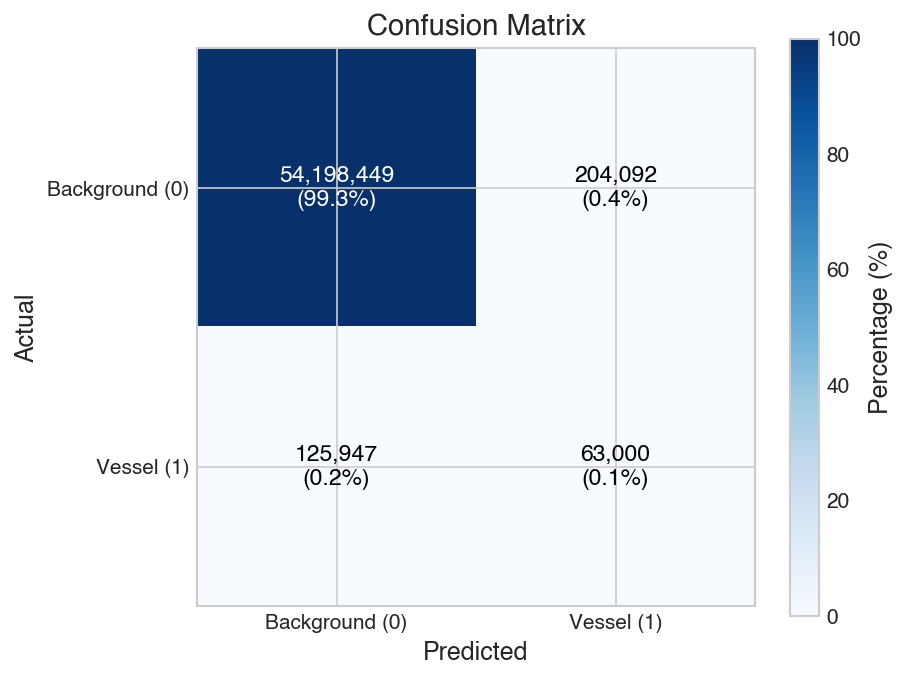

In [50]:
cm_arr = np.array(global_metrics['confusion_matrix'])
cm_pct = cm_arr.astype(float) / cm_arr.sum() * 100

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=100)

labels = ['Background (0)', 'Vessel (1)']
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(labels); ax.set_yticklabels(labels)
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

for i in range(2):
    for j in range(2):
        color = 'white' if cm_pct[i, j] > 50 else 'black'
        ax.text(j, i, f'{cm_arr[i,j]:,}\n({cm_pct[i,j]:.1f}%)',
                ha='center', va='center', color=color, fontsize=11, fontweight='bold')

fig.colorbar(im, ax=ax, label='Percentage (%)')
fig.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
plt.show()

### Chart 2 — Precision-Recall Curve

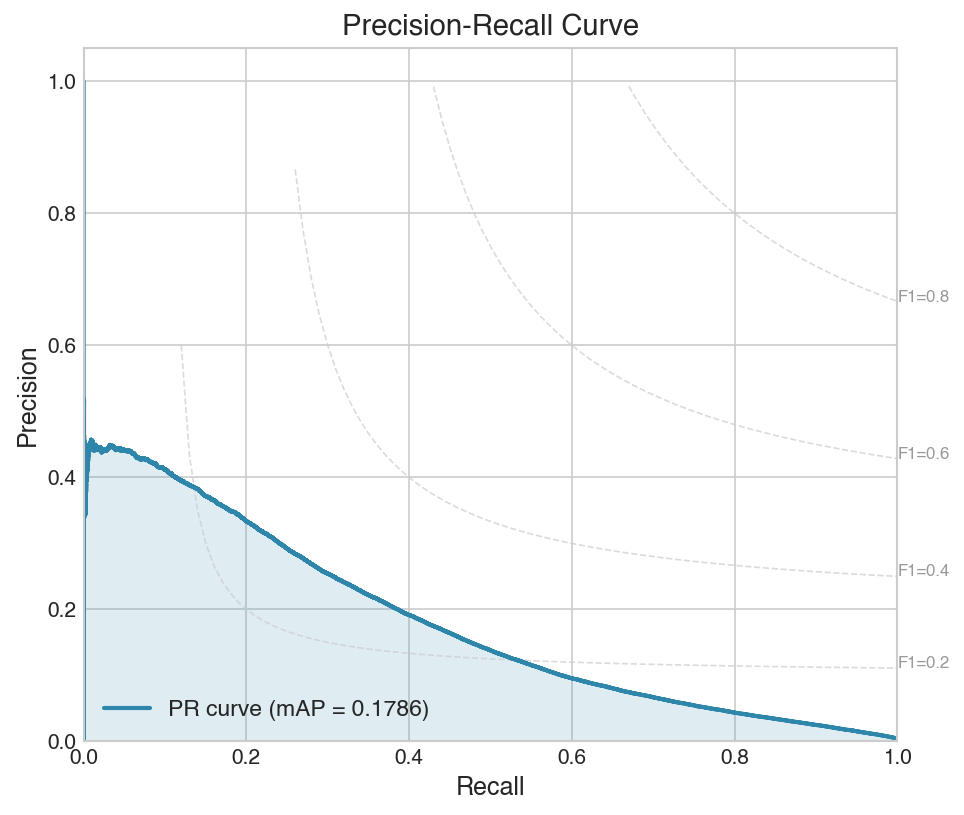

In [51]:
fig, ax = plt.subplots(figsize=(7, 6))

# Iso-F1 reference lines
for f1_val in [0.2, 0.4, 0.6, 0.8]:
    x = np.linspace(0.01, 1, 100)
    y = f1_val * x / (2 * x - f1_val)
    valid = (y > 0) & (y <= 1)
    ax.plot(x[valid], y[valid], '--', color='#CCCCCC', linewidth=0.8, alpha=0.7)
    idx_label = np.where(valid)[0]
    if len(idx_label) > 0:
        li = idx_label[-1]
        ax.annotate(f'F1={f1_val}', xy=(x[li], y[li]), fontsize=8, color='#999999')

mAP = global_metrics['mAP']
ax.plot(pr_rec, pr_prec, color=COLORS['steel_blue'], linewidth=2,
        label=f'PR curve (mAP = {mAP:.4f})')
ax.fill_between(pr_rec, pr_prec, alpha=0.15, color=COLORS['steel_blue'])
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.set_xlim([0, 1]); ax.set_ylim([0, 1.05])
ax.legend(loc='lower left', fontsize=11)
fig.savefig(os.path.join(OUTPUT_DIR, 'precision_recall_curve.png'))
plt.show()

### Chart 3 — ROC Curve

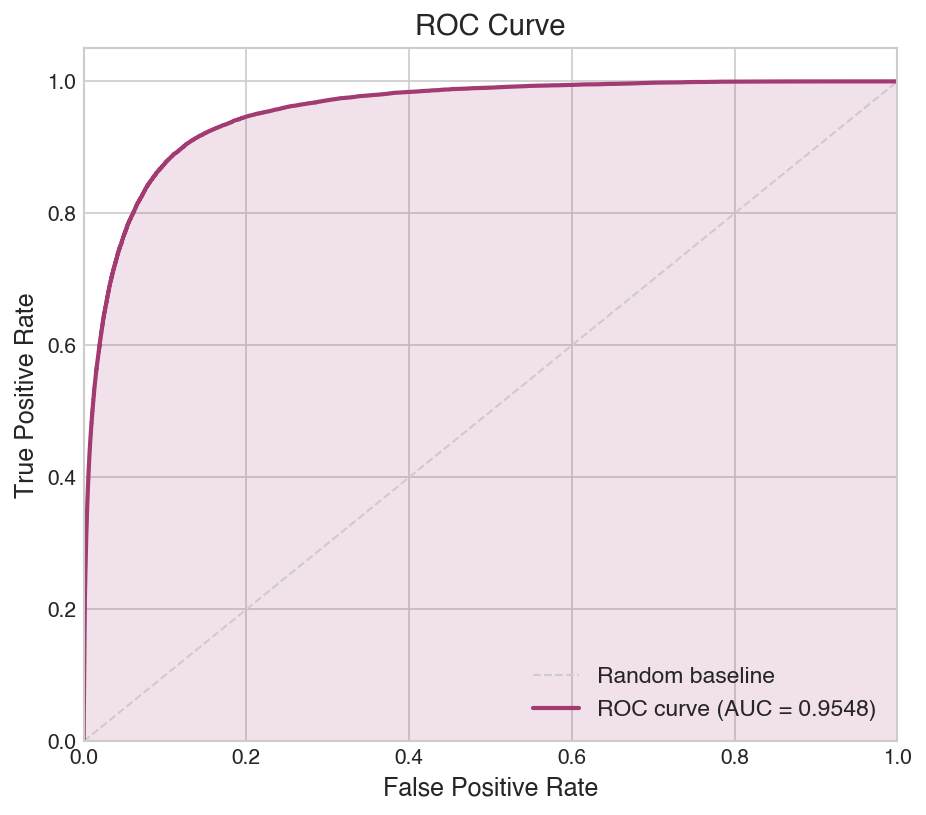

In [52]:
auc_val = global_metrics['roc_auc']

fig, ax = plt.subplots(figsize=(7, 6))
ax.plot([0, 1], [0, 1], '--', color='#CCCCCC', linewidth=1, label='Random baseline')
ax.plot(fpr_arr, tpr_arr, color=COLORS['deep_rose'], linewidth=2,
        label=f'ROC curve (AUC = {auc_val:.4f})')
ax.fill_between(fpr_arr, tpr_arr, alpha=0.15, color=COLORS['deep_rose'])
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.set_xlim([0, 1]); ax.set_ylim([0, 1.05])
ax.legend(loc='lower right', fontsize=11)
fig.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'))
plt.show()

### Chart 4 — Per-Image Metric Distributions

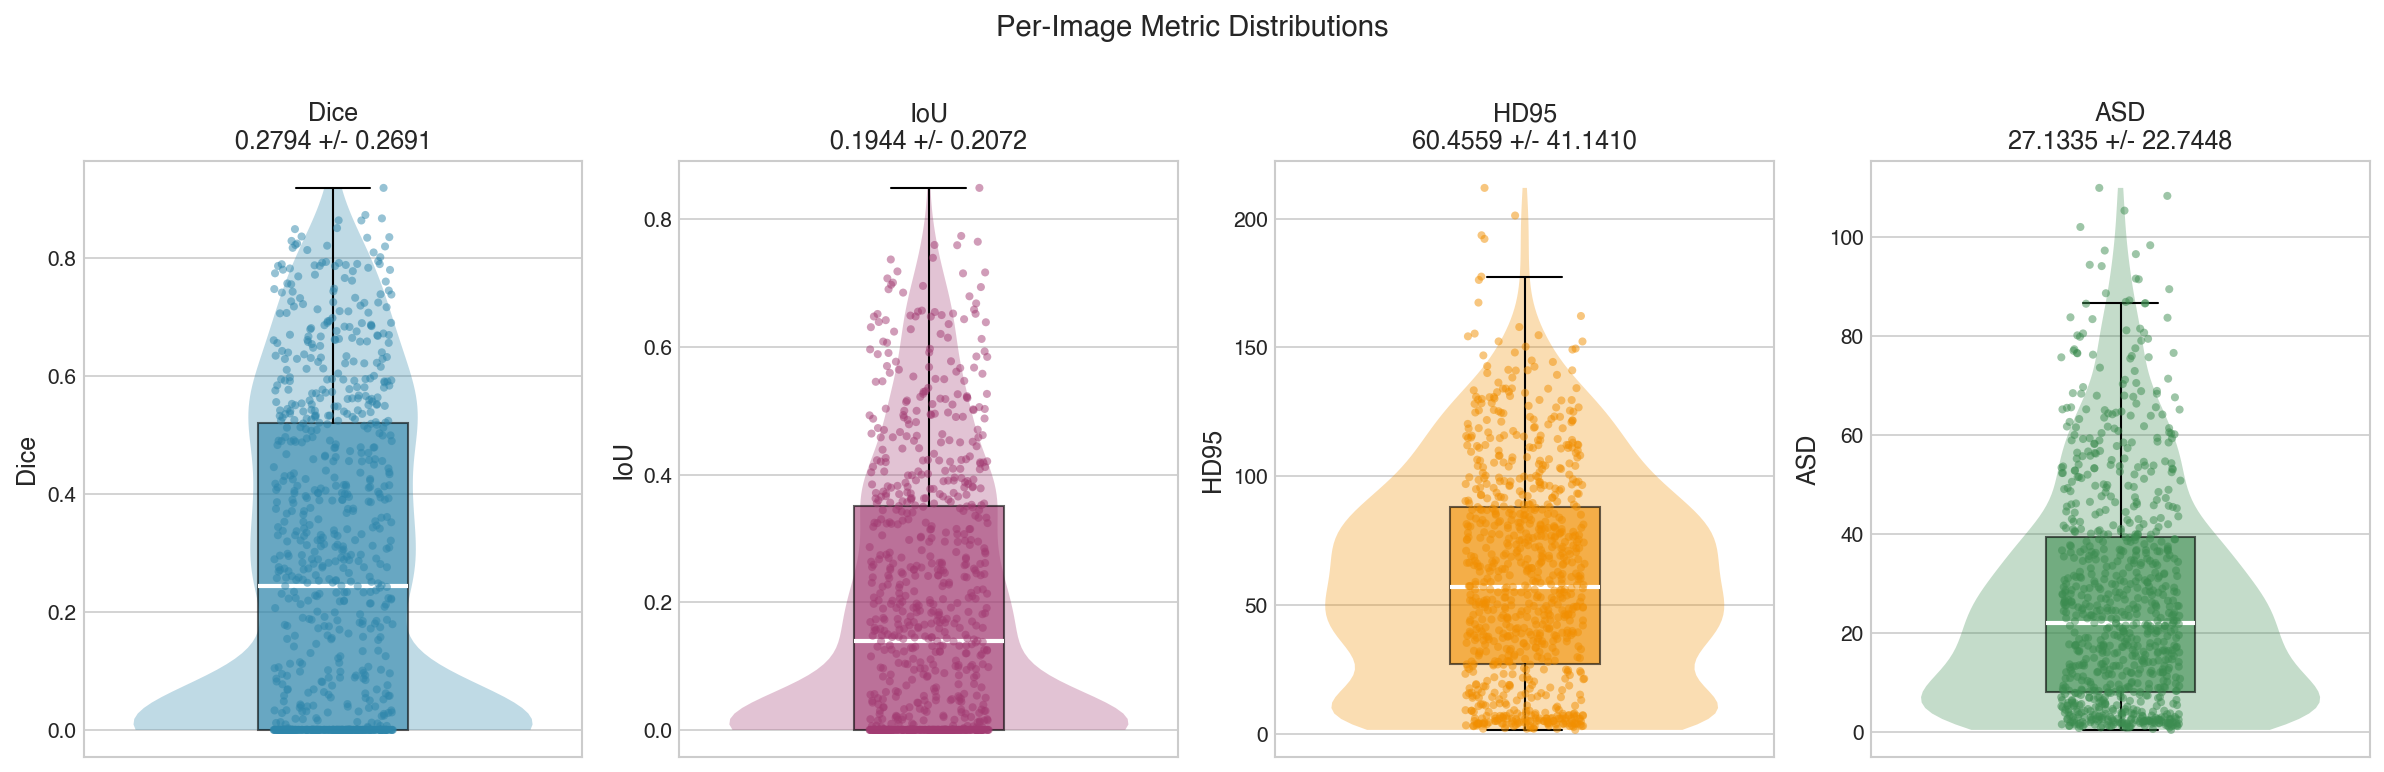

In [53]:
metric_keys   = ['dice', 'iou', 'hd95', 'asd']
display_names = ['Dice', 'IoU', 'HD95', 'ASD']
palette = [COLORS['steel_blue'], COLORS['deep_rose'],
           COLORS['warm_amber'], COLORS['forest_green']]

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, key, name, color in zip(axes, metric_keys, display_names, palette):
    vals = [m[key] for m in per_image_metrics if not np.isnan(m[key])]
    if not vals:
        ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(name); continue

    # Violin
    parts = ax.violinplot(vals, positions=[0], showextrema=False, widths=0.8)
    for pc in parts['bodies']:
        pc.set_facecolor(color); pc.set_alpha(0.3)

    # Box
    bp = ax.boxplot(vals, positions=[0], widths=0.3, patch_artist=True,
                    showfliers=False, zorder=3)
    bp['boxes'][0].set_facecolor(color); bp['boxes'][0].set_alpha(0.6)
    bp['medians'][0].set_color('white'); bp['medians'][0].set_linewidth(2)

    # Strip (jittered points)
    jitter = np.random.RandomState(RNG_SEED).uniform(-0.12, 0.12, len(vals))
    ax.scatter(jitter, vals, color=color, alpha=0.5, s=15, zorder=4, edgecolors='none')

    ax.set_title(f'{name}\n{np.mean(vals):.4f} +/- {np.std(vals):.4f}', fontsize=12)
    ax.set_xticks([]); ax.set_ylabel(name)

fig.suptitle('Per-Image Metric Distributions', fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'metric_distributions.png'))
plt.show()

### Chart 5 — Threshold Sensitivity Analysis

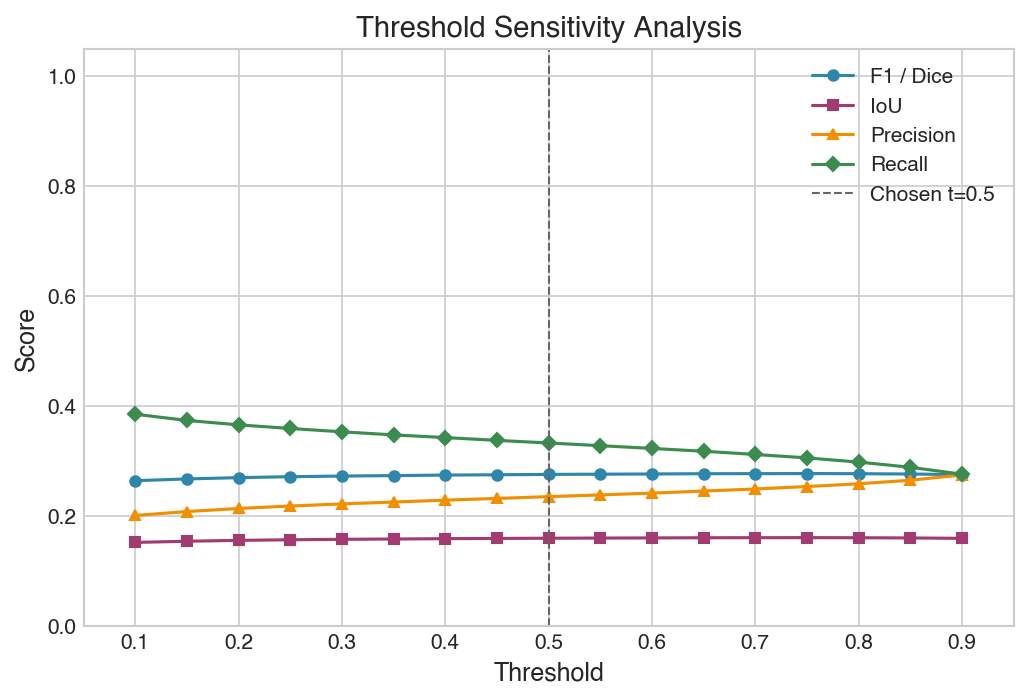

In [54]:
thresholds = sorted(threshold_data.keys())

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(thresholds, [threshold_data[t]['f1']        for t in thresholds],
        '-o', color=COLORS['steel_blue'],   label='F1 / Dice',  markersize=5)
ax.plot(thresholds, [threshold_data[t]['iou']       for t in thresholds],
        '-s', color=COLORS['deep_rose'],    label='IoU',        markersize=5)
ax.plot(thresholds, [threshold_data[t]['precision']  for t in thresholds],
        '-^', color=COLORS['warm_amber'],   label='Precision',  markersize=5)
ax.plot(thresholds, [threshold_data[t]['recall']    for t in thresholds],
        '-D', color=COLORS['forest_green'], label='Recall',     markersize=5)

ax.axvline(x=THRESHOLD, color='#666666', linestyle='--', linewidth=1,
           label=f'Chosen t={THRESHOLD}')

ax.set_xlabel('Threshold'); ax.set_ylabel('Score')
ax.set_title('Threshold Sensitivity Analysis')
ax.set_xlim([0.05, 0.95]); ax.set_ylim([0, 1.05])
ax.legend(loc='best', fontsize=10)
fig.savefig(os.path.join(OUTPUT_DIR, 'threshold_analysis.png'))
plt.show()

### Chart 6 — Qualitative Results (Best 4 + Worst 4)

Overlay legend: **Green** = TP, **Red** = FP, **Blue** = FN

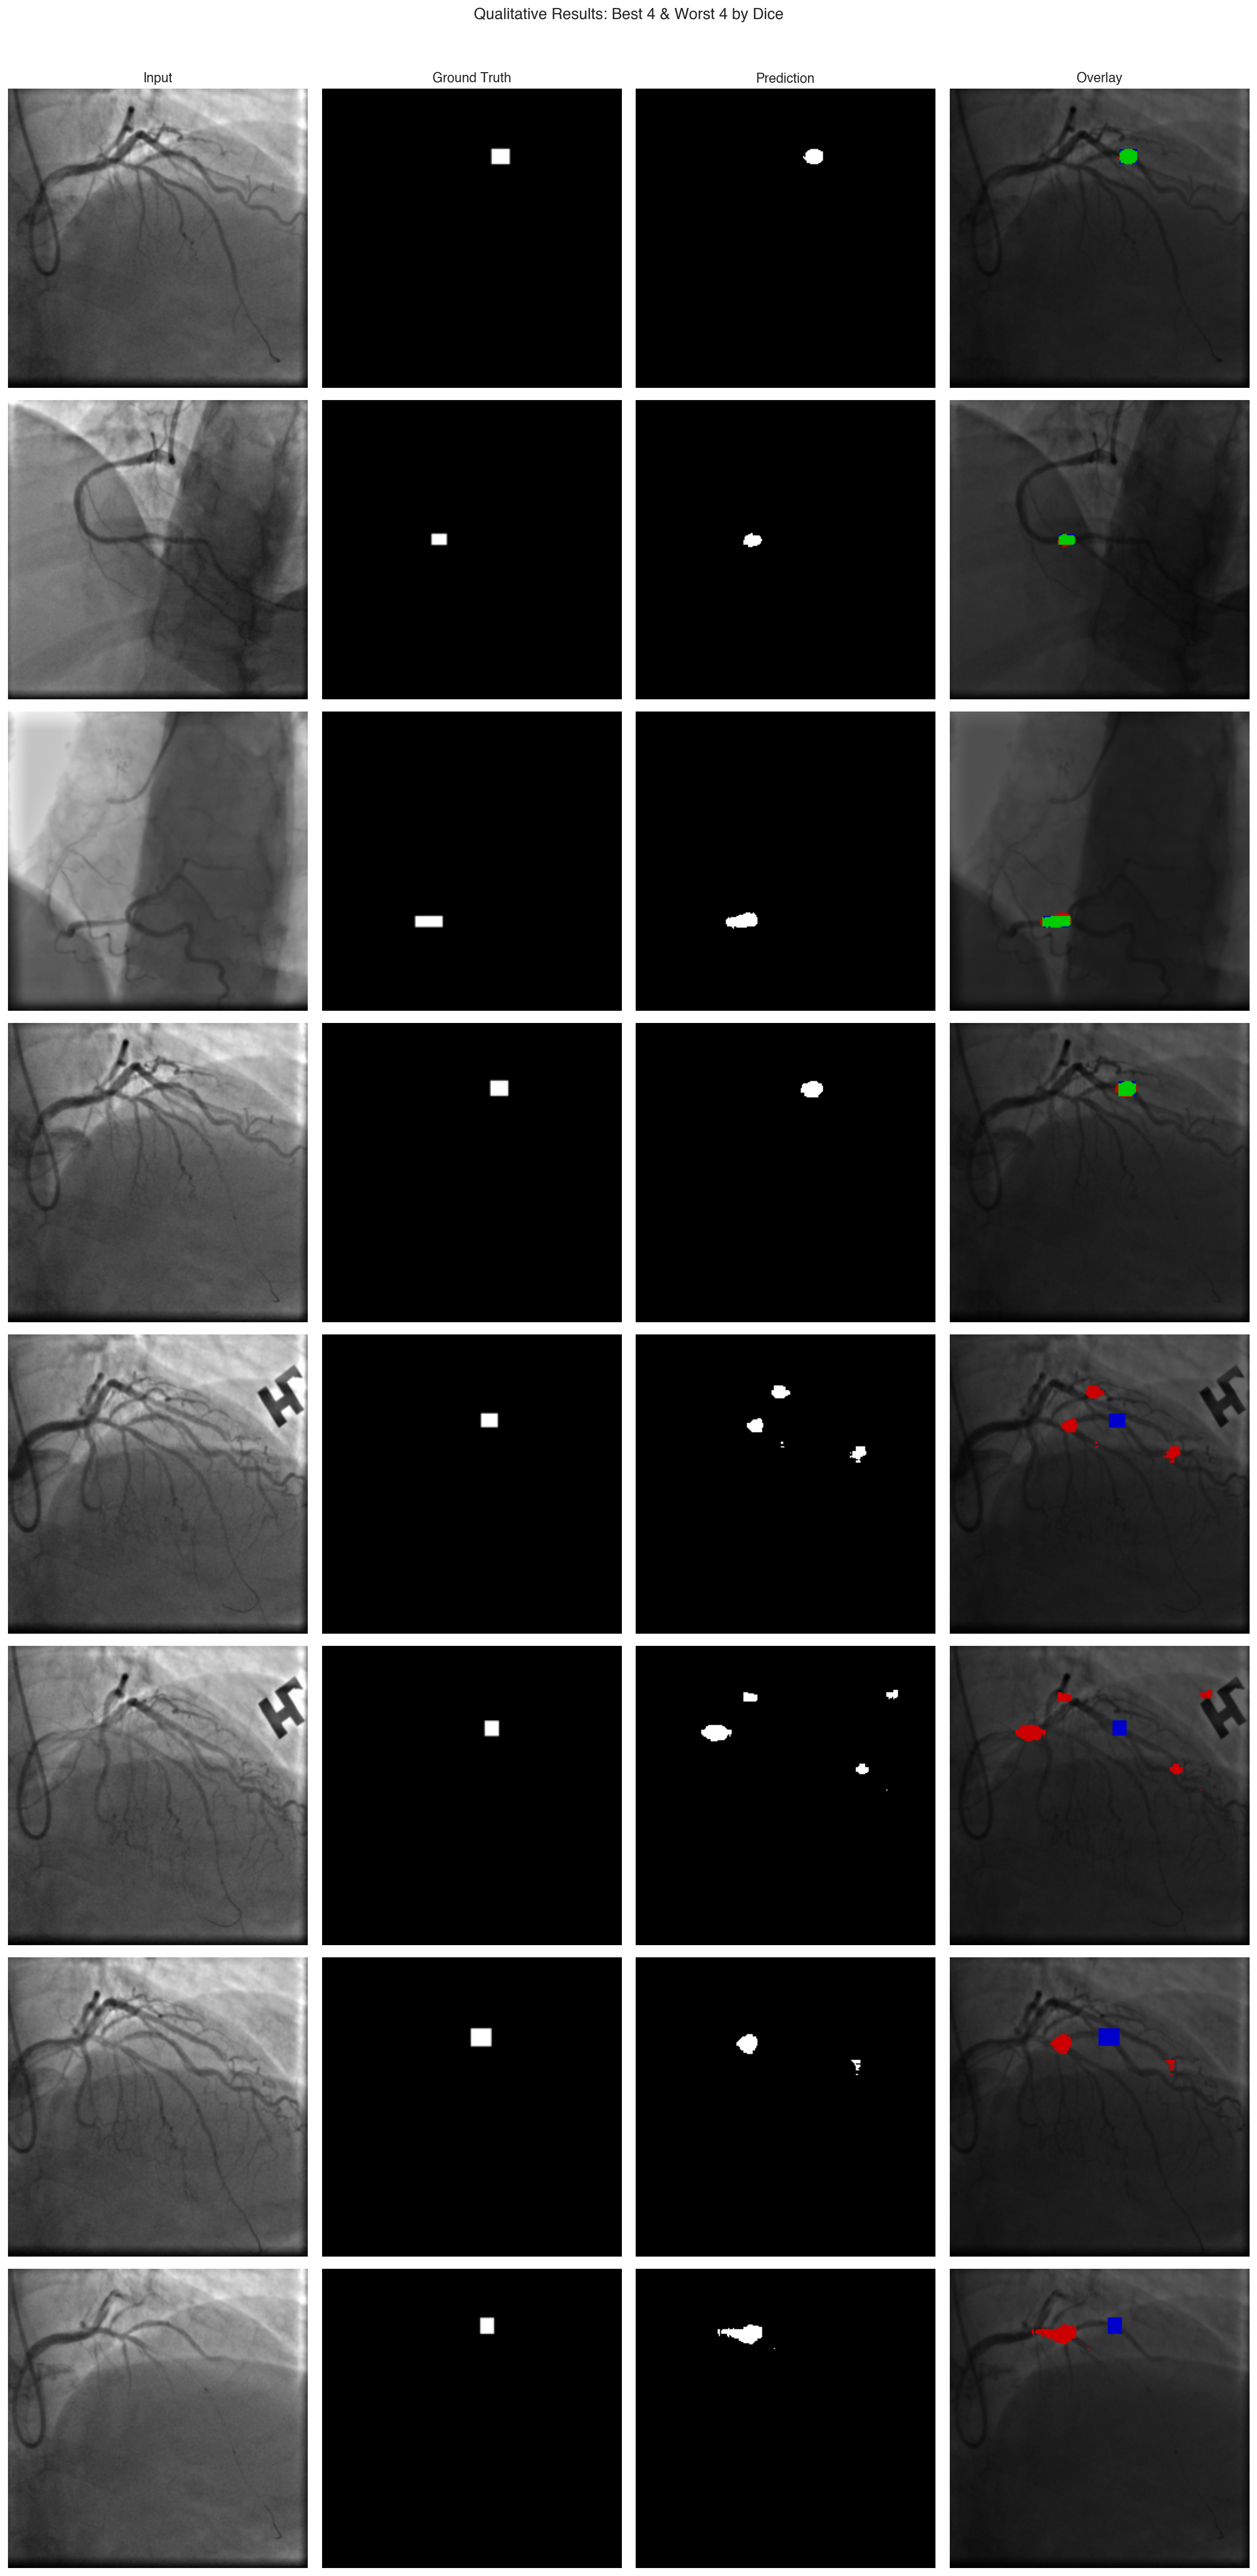

In [55]:
sorted_by_dice = sorted(per_image_metrics, key=lambda m: m['dice'])
worst4 = sorted_by_dice[:4]
best4  = sorted_by_dice[-4:][::-1]
selected = best4 + worst4
row_labels = ['Best'] * 4 + ['Worst'] * 4

fig, axes = plt.subplots(len(selected), 4, figsize=(16, 4 * len(selected)))
col_titles = ['Input', 'Ground Truth', 'Prediction', 'Overlay']

for row, (m, label) in enumerate(zip(selected, row_labels)):
    r    = results[m['index']]
    img  = r['image']                                        # (3, H, W)
    gt   = r['gt']                                           # (H, W)
    prob = r['prob']                                         # (H, W)
    pred   = (prob >= THRESHOLD).astype(np.uint8)
    gt_bin = (gt   >= 0.5).astype(np.uint8)

    # Denormalize for display
    img_disp = np.transpose(img, (1, 2, 0))
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)

    # Overlay
    overlay = img_disp * 0.4
    overlay[ (pred & gt_bin).astype(bool), :] = [0.0, 0.8, 0.0]   # TP green
    overlay[ (pred & ~gt_bin).astype(bool), :] = [0.8, 0.0, 0.0]  # FP red
    overlay[(~pred & gt_bin).astype(bool), :] = [0.0, 0.0, 0.8]   # FN blue
    overlay = np.clip(overlay, 0, 1)

    axes[row, 0].imshow(img_disp)
    axes[row, 1].imshow(gt,   cmap='gray', vmin=0, vmax=1)
    axes[row, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
    axes[row, 3].imshow(overlay)

    for col in range(4):
        axes[row, col].axis('off')
        if row == 0:
            axes[row, col].set_title(col_titles[col], fontsize=12, fontweight='bold')

    axes[row, 0].set_ylabel(f'{label} #{row % 4 + 1}\nDice={m["dice"]:.3f}',
                            fontsize=10, rotation=0, labelpad=70, va='center')

fig.suptitle('Qualitative Results: Best 4 & Worst 4 by Dice',
             fontsize=14, fontweight='bold', y=1.01)
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, 'qualitative_results.png'))
plt.show()

### Chart 7 — Metrics Dashboard

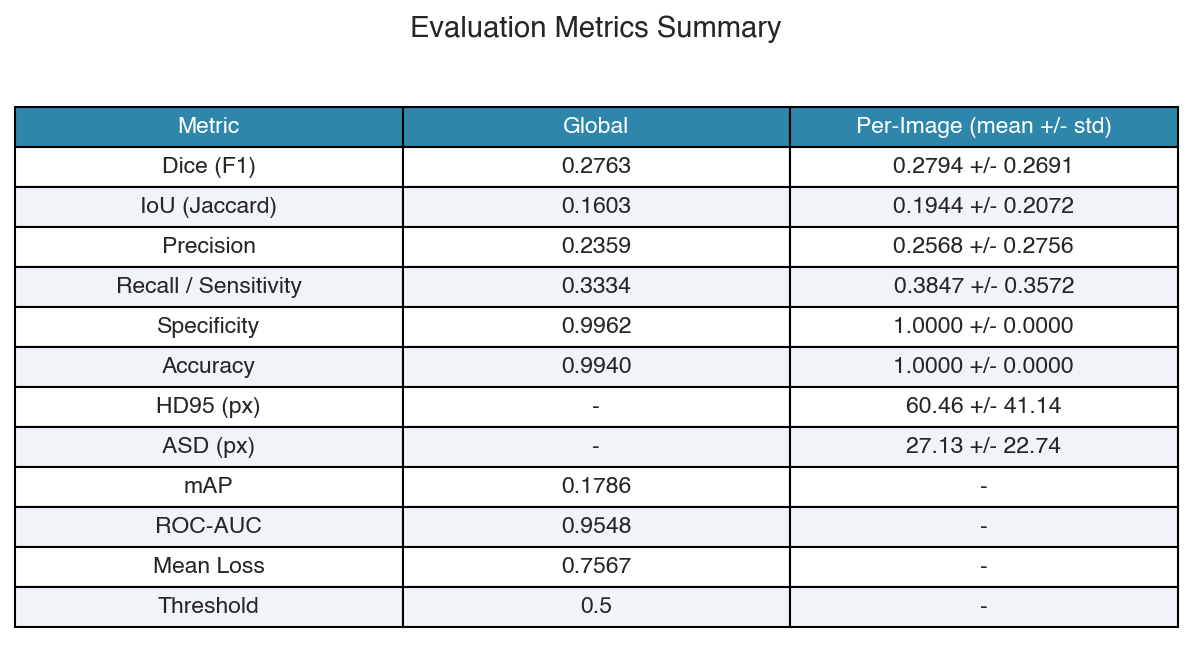

In [56]:
def _fmt_mean_std(key):
    mn = global_metrics.get(f'{key}_mean', float('nan'))
    sd = global_metrics.get(f'{key}_std',  float('nan'))
    if np.isnan(mn): return 'N/A'
    if key in ('hd95', 'asd'):
        return f'{mn:.2f} +/- {sd:.2f}'
    return f'{mn:.4f} +/- {sd:.4f}'

rows = [
    ['Dice (F1)',           f'{g["dice"]:.4f}',        _fmt_mean_std('dice')],
    ['IoU (Jaccard)',       f'{g["iou"]:.4f}',         _fmt_mean_std('iou')],
    ['Precision',           f'{g["precision"]:.4f}',   _fmt_mean_std('precision')],
    ['Recall / Sensitivity',f'{g["recall"]:.4f}',      _fmt_mean_std('recall')],
    ['Specificity',         f'{g["specificity"]:.4f}', _fmt_mean_std('specificity')],
    ['Accuracy',            f'{g["accuracy"]:.4f}',    _fmt_mean_std('accuracy')],
    ['HD95 (px)',           '-',                        _fmt_mean_std('hd95')],
    ['ASD (px)',            '-',                        _fmt_mean_std('asd')],
    ['mAP',                 f'{g["mAP"]:.4f}',        '-'],
    ['ROC-AUC',             f'{g["roc_auc"]:.4f}',    '-'],
    ['Mean Loss',           f'{g["mean_loss"]:.4f}',  '-'],
    ['Threshold',           f'{THRESHOLD}',            '-'],
]
col_labels = ['Metric', 'Global', 'Per-Image (mean +/- std)']

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')
ax.set_title('Evaluation Metrics Summary', fontsize=14, fontweight='bold', pad=20)

table = ax.table(cellText=rows, colLabels=col_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.0, 1.6)

for j in range(len(col_labels)):
    cell = table[0, j]
    cell.set_facecolor(COLORS['steel_blue'])
    cell.set_text_props(color='white', fontweight='bold')

for i in range(1, len(rows) + 1):
    for j in range(len(col_labels)):
        table[i, j].set_facecolor('#F0F4F8' if i % 2 == 0 else 'white')

fig.savefig(os.path.join(OUTPUT_DIR, 'metrics_dashboard.png'))
plt.show()

---
## 7. Export Metrics JSON

In [57]:
export = {
    'threshold': THRESHOLD,
    'global': global_metrics,
    'threshold_sensitivity': {str(k): v for k, v in threshold_data.items()},
    'per_image': [
        {k: (v if not (isinstance(v, float) and np.isnan(v)) else None)
         for k, v in m.items()}
        for m in per_image_metrics
    ],
}

json_path = os.path.join(OUTPUT_DIR, 'metrics.json')
with open(json_path, 'w') as f:
    json.dump(export, f, indent=2)

print(f'Saved {json_path}  ({os.path.getsize(json_path) / 1024:.1f} KB)')

Saved ./evaluation/metrics.json  (272.2 KB)


---
## Done

All 7 charts + `metrics.json` have been saved to the output directory.